As a part of #100DaysOfMLCode have started with this dataset due to lack of ML exposure. For the initial parts will be implementing various alogroithms inspired from other submissions. 

In [90]:
# Packages used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer

In [91]:
#Loading the Data as Pandas Data Frame
train_ft_df = pd.read_csv('train_features.csv')
train_lab_df = pd.read_csv('train_label.csv')
train_df = train_ft_df.merge(train_lab_df,on ='id')

In [92]:
#Dealing With numerical data...
print(train_df.shape)
temp = train_df.dtypes == 'int64' 
temp_2 = train_df.dtypes == 'float64'
numeric_fetrs = temp | temp_2
numeric_fetrs['id','latitude','longitude','num_private','amount_tsh'] = False
print((train_df.loc[:,numeric_fetrs]== 0).sum())
print(train_df[['population','region_code','amount_tsh']].corr())
print(train_df[['construction_year','region_code','amount_tsh']].corr())

#(train_df['population'] == 0).sum()

(59400, 41)
gps_height           20438
region_code              0
district_code           23
population           21381
construction_year    20709
dtype: int64
             population  region_code  amount_tsh
population     1.000000     0.094088    0.016288
region_code    0.094088     1.000000   -0.026813
amount_tsh     0.016288    -0.026813    1.000000
                   construction_year  region_code  amount_tsh
construction_year           1.000000     0.031724    0.067915
region_code                 0.031724     1.000000   -0.026813
amount_tsh                  0.067915    -0.026813    1.000000


Cleaning up Numerical Data
It was found that apart from the allowed zero features gps_height,population and construction_year had alarmingly high number of zeros. gps_height could be zero due to a well being at ground level. poulation/construction_year were not correlated any of the suspected features. Hence simple imputing tecniques will be used.

In [93]:
impute = Imputer(0,'median')
impute.fit_transform(train_df[['population','construction_year']])

array([[ 109., 1999.],
       [ 280., 2010.],
       [ 250., 2009.],
       ...,
       [ 150., 2000.],
       [ 150., 2000.],
       [ 150., 2002.]])

In [94]:
exempt=['amount_tsh',  'gps_height',  'num_private',
       'basin', 'region', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'scheme_management',  'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group','id','longitude','latitude']

train_df = train_df.apply(lambda x: x.mask(x.map(x.value_counts())<20, 'other') if x.name not in exempt else x)

In [95]:
## To reduce redundant Features droping sub-gorup classifiers.
train_df = train_df.drop(['quantity','waterpoint_type'],axis = 1);


In [96]:
#Converting Categorical Features as one hot encoded values
train_df.dtypes
#train_df = pd.get_dummies(train_df,dummy_na = True)
#Scaling only amount_tsh,gps_height, population
scale_Fetrs = ['amount_tsh','gps_height','population']
scaler = MinMaxScaler(feature_range = (0,20))
train_df[scale_Fetrs] = scaler.fit_transform(train_df[scale_Fetrs])


In [97]:
# Should remove name of water point as it contains no valuable information
#Non Info Features = wpt_name,recorded_by,num_private
train_df  = train_df.drop(['wpt_name','num_private','recorded_by'],axis = 1)
#print(train_df.groupby['wpt_name'].size())

In [98]:
print(train_df.groupby(['payment','payment_type']).size())
#As This two features are redundant dropping one
train_df = train_df.drop(['payment_type'],axis = 1)

payment                payment_type
never pay              never pay       25348
other                  other            1054
pay annually           annually         3642
pay monthly            monthly          8300
pay per bucket         per bucket       8985
pay when scheme fails  on failure       3914
unknown                unknown          8157
dtype: int64


In [99]:
print(train_df.groupby(['water_quality','quality_group']).size())
# will drop the sub_group water_quality
train_df = train_df.drop(['quality_group'],axis = 1)

water_quality       quality_group
coloured            colored            490
fluoride            fluoride           200
fluoride abandoned  fluoride            17
milky               milky              804
salty               salty             4856
salty abandoned     salty              339
soft                good             50818
unknown             unknown           1876
dtype: int64


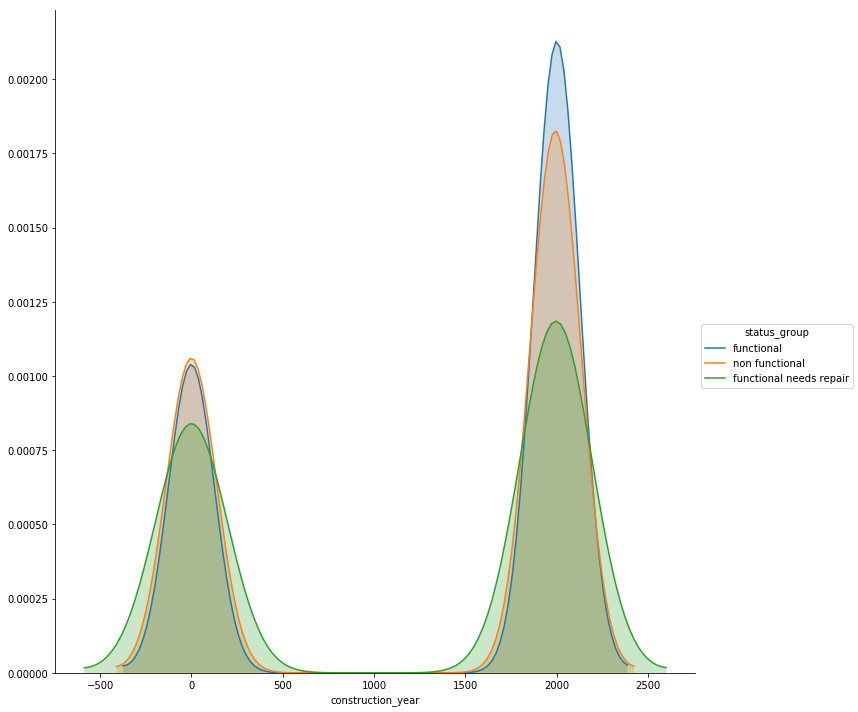

In [100]:
sns.FacetGrid(train_df, hue='status_group',size=10).map(sns.kdeplot, 'construction_year', shade=True).add_legend()

#train_df['construction_year'] = train_df['construction_year'].replace(0,train_df['construction_year'].median())
# keeping the construction year as newer ones are less faulty.

In [101]:
train_df.groupby(['source','source_type','source_class']).size()
#keeping the source_type
train_df = train_df.drop(['source','source_class'],axis = 1)

In [102]:
train_df.groupby(['extraction_type','extraction_type_group','extraction_type_class']).size()
#dropping extraction_type_class
train_df = train_df.drop(['extraction_type_class','extraction_type'],axis = 1)

In [103]:
# Due to spcae constrain will be using factorize over one-hot encoder
# complete cleaning Data and EDA.
train_df.groupby(['management','management_group']).size()
train_df = train_df.drop(['management_group'],axis = 1)

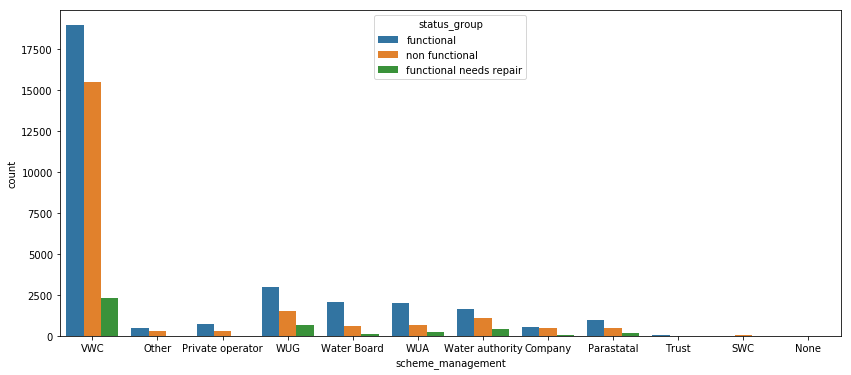

In [104]:
#count Plot
train_df.isnull().sum()
train_df.groupby(['scheme_management','scheme_name']).size()
plt.figure(figsize=(14,6))
sns.countplot(data = train_df,x = 'scheme_management',hue = 'status_group')


In [105]:
# Dropping Categorical Features with more than 3000 missing values
cat_fetrs = train_df.dtypes == object
fetrs_3000 = train_df.isnull().sum() > 3000
train_df = train_df.drop(train_df.columns[cat_fetrs & fetrs_3000],axis = 1) 
train_df.isnull().sum()

id                         0
amount_tsh                 0
date_recorded              0
gps_height                 0
longitude                  0
latitude                   0
basin                      0
subvillage               371
region                     0
region_code                0
district_code              0
lga                        0
ward                       0
population                 0
construction_year          0
extraction_type_group      0
management                 0
payment                    0
water_quality              0
quantity_group             0
source_type                0
waterpoint_type_group      0
status_group               0
dtype: int64

In [106]:
#Dealing with Geographic Location 
train_df.groupby(['subvillage','region','region_code','lga','ward']).sum()
train_df = train_df.drop(['subvillage','region_code','lga','ward','region'],axis = 1)
train_df = train_df.drop(['date_recorded'], axis  = 1)

In [107]:
train_df.dtypes
temp = train_df['status_group']
labels,uniques = temp.factorize(sort  = True) # Check This
train_df = train_df.drop(['status_group'], axis = 1)
train_df = pd.get_dummies(train_df, dummy_na = True)
train_df = train_df.assign(status_group = labels)

In [108]:
train_df.dtypes

id                                            int64
amount_tsh                                  float64
gps_height                                  float64
longitude                                   float64
latitude                                    float64
district_code                                 int64
population                                  float64
construction_year                             int64
basin_Internal                                uint8
basin_Lake Nyasa                              uint8
basin_Lake Rukwa                              uint8
basin_Lake Tanganyika                         uint8
basin_Lake Victoria                           uint8
basin_Pangani                                 uint8
basin_Rufiji                                  uint8
basin_Ruvuma / Southern Coast                 uint8
basin_Wami / Ruvu                             uint8
basin_nan                                     uint8
extraction_type_group_afridev                 uint8
extraction_t

In [109]:
# will be using graident booosting using xgBoost
#Split the Data as 70:30
op_temp = train_test_split(train_df,test_size  = 0.3, train_size = 0.7)
train_df = op_temp[0]
y_train = train_df['status_group'] 
x_train = train_df.drop(['status_group','id'],axis = 1)
valid_df = op_temp[1]
y_valid  = valid_df ['status_group']
x_valid  = valid_df.drop(['status_group','id'], axis = 1)

In [110]:
model = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 14, colsample_bytree = .4)
#model=XGBClassifier(learning_rate=0.1,n_estimators=100)
model.fit(x_train,y_train)
y_pred=model.predict(x_valid)
accuracy_score(y_valid, y_pred, normalize=True)

C:\Users\sram0\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.812962962962963

<Figure size 1440x1152 with 0 Axes>

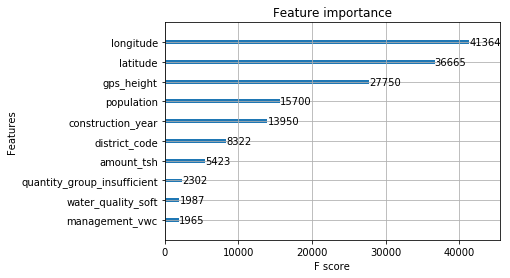

             precision    recall  f1-score   support

          0       0.80      0.91      0.85      9652
          1       0.61      0.28      0.39      1257
          2       0.86      0.78      0.81      6911

avg / total       0.81      0.81      0.80     17820



In [111]:
# plot feature importance
plt.figure(figsize=(20,16))
plot_importance(model,max_num_features  = 10)
plt.show()
print(classification_report(y_valid, y_pred))


In [112]:
# Feature Engineering
# Learn Gradient Boosting
# Dimeonsality Reduction
# Improve Plotting
#Problem is with predicting "Functional and needs repair"
# need to check date_recorded and plot categorical vals.